In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, train_test_split
from sklearn.metrics import precision_score,f1_score, accuracy_score, classification_report,confusion_matrix,classification_report

from sklearn.utils import shuffle
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle
from sklearn.metrics import confusion_matrix
# importing sys
import sys
# adding helper_func to the system path
sys.path.insert(0, '../helper_functions/')
# importing actual functions
from helper_functions import preds_N_cm,plot_xgb_importance

#from oversampler_funtion import over_sampler ### NEED TO IMPORT
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_columns", 100)

xgb.__version__

'1.6.0'

In [2]:
building = pd.read_csv("../../Data/Complete_N_Cleaned.csv")
building.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,1,1,9,288,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,1,0,0,0,damaged_used_in_risk,3,major_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,1,0,0,0,damaged_repaired_and_used,5,reconstruction,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,2,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,2,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,0,1,0,0,0,0,0,0,0,0,0,damaged_repaired_and_used,1,minor_repair,private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


In [3]:
print('confirming no nulls: ',building.isnull().sum().sum())
building.dtypes

confirming no nulls:  0


building_id                                 int64
district_id                                 int64
vdcmun_id                                   int64
ward_id                                     int64
count_floors_pre_eq                         int64
count_floors_post_eq                        int64
age_building                                int64
plinth_area_sq_ft                           int64
height_ft_pre_eq                            int64
height_ft_post_eq                           int64
land_surface_condition                     object
foundation_type                            object
roof_type                                  object
ground_floor_type                          object
other_floor_type                           object
position                                   object
plan_configuration                         object
has_superstructure_adobe_mud                int64
has_superstructure_mud_mortar_stone         int64
has_superstructure_stone_flag               int64


In [4]:
# prepping original data to dummify
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical = ['object']
numdf = building.copy().select_dtypes(include=numerics)
catdf = building.copy().select_dtypes(include=categorical)
#need to catdf
catdf.head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,technical_solution_proposed,legal_ownership_status
0,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_used_in_risk,major_repair,private
1,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,reconstruction,private
2,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
3,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private
4,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,damaged_repaired_and_used,minor_repair,private


In [5]:
# will dummify these to pass into models catdf.head()
dummified_1 = pd.get_dummies(data=catdf,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1.head()

(762106, 72)


,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,plan_configuration_others,plan_configuration_rectangular,plan_configuration_square,plan_configuration_t_shape,plan_configuration_u_shape,condition_post_eq_damaged_not_used,condition_post_eq_damaged_repaired_and_used,condition_post_eq_damaged_rubble_clear,condition_post_eq_damaged_rubble_clear_new_building_built,condition_post_eq_damaged_rubble_unclear,condition_post_eq_damaged_used_in_risk,condition_post_eq_not_damaged,technical_solution_proposed_minor_repair,technical_solution_proposed_no_need,technical_solution_proposed_reconstruction,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public
0,120101000011,12,1207,120703,1,1,9,288,9,9,0,1,0,0,0,0,0,1,0,0,0,3,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,120101000021,12,1207,120703,1,1,15,364,9,9,0,1,0,0,0,0,0,1,0,0,0,5,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
2,120101000031,12,1207,120703,1,1,20,384,9,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
3,120101000041,12,1207,120703,1,1,20,312,9,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
4,120101000051,12,1207,120703,1,1,30,308,9,9,0,1,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


In [8]:
# prepping my training and testing batches double checking class balances
X = dummified_1.drop(columns = ['building_id','damage_grade']) 
y = dummified_1['damage_grade']-1

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

#### Important Note: I had to alter my class from 1-5 to 0-4 for the classifier below.
The baseline is 36%, since we have some pretty imbalanced classes thus our class 4 (grade 5).

In [28]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=10,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)

CPU times: user 4min 38s, sys: 3.93 s, total: 4min 41s
Wall time: 1min 46s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softmax', predictor='auto',
              random_state=42, reg_alpha=0, ...)

Accuracy: 88.13%

(micro) precision score:  0.8812924152482325         (macro) precision score:  0.8725009399404282
(micro) f1 score:  0.8812924152482325                (macro) f1 score:  0.8653277476604968

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     19704
           1       0.79      0.85      0.82     21814
           2       0.79      0.74      0.76     34103
           3       0.80      0.91      0.85     45961
           4       1.00      0.95      0.97     68945

    accuracy                           0.88    190527
   macro avg       0.87      0.86      0.87    190527
weighted avg       0.89      0.88      0.88    190527



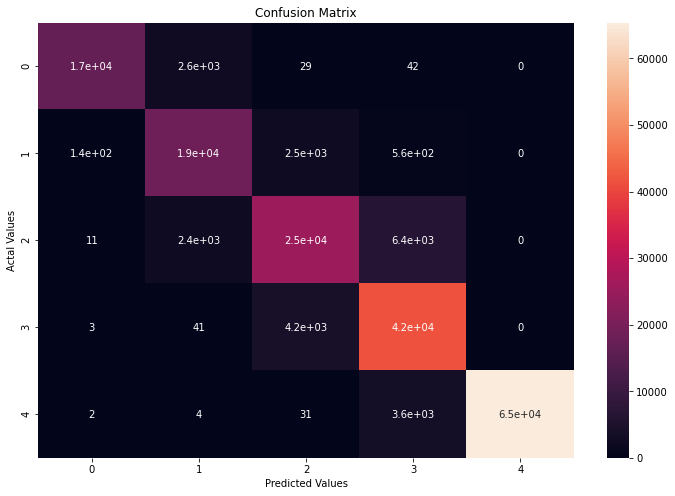

In [29]:
preds_N_cm(model,X_train,y_train,X_test,y_test)   

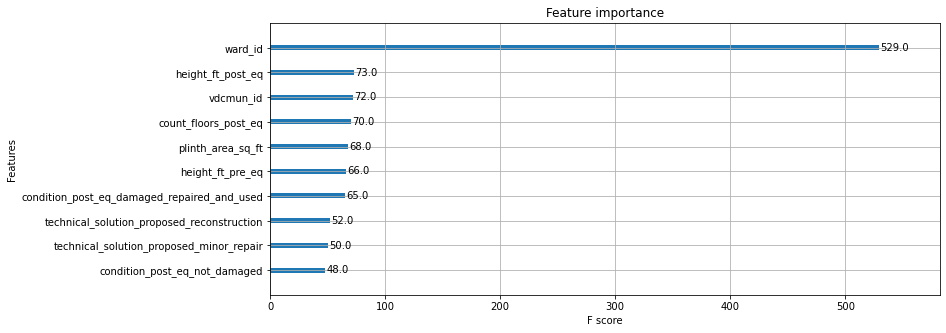

In [30]:
plot_xgb_importance(model,num_features=10)

Attempting use PCA and only slightly decreased performance so will need to reapproach. It was noteable to consider that there was likely some loss in the ward_id (location) feature when transforming the train and testing data.

In [12]:
%%time 
# initiate PCA and classifier
pca = PCA()
# standardize data
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.fit_transform(X_test)

# transform / fit scaled data into pca
X_train_transformed = pca.fit_transform(Xs_train)
X_test_transformed = pca.transform(Xs_test)

# instantiating second model same as above with pca - standard scaler model
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=10,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train_transformed,y_train)

CPU times: user 21min 29s, sys: 17.8 s, total: 21min 47s
Wall time: 8min 15s


Accuracy: 87.45%

(micro) precision score:  0.8744587381316034         (macro) precision score:  0.8654779032771319
(micro) f1 score:  0.8744587381316035                (macro) f1 score:  0.8582779965820562

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.98      0.86      0.92     19704
           1       0.78      0.84      0.81     21814
           2       0.78      0.73      0.76     34103
           3       0.79      0.90      0.84     45961
           4       0.99      0.94      0.97     68945

    accuracy                           0.87    190527
   macro avg       0.87      0.86      0.86    190527
weighted avg       0.88      0.87      0.88    190527



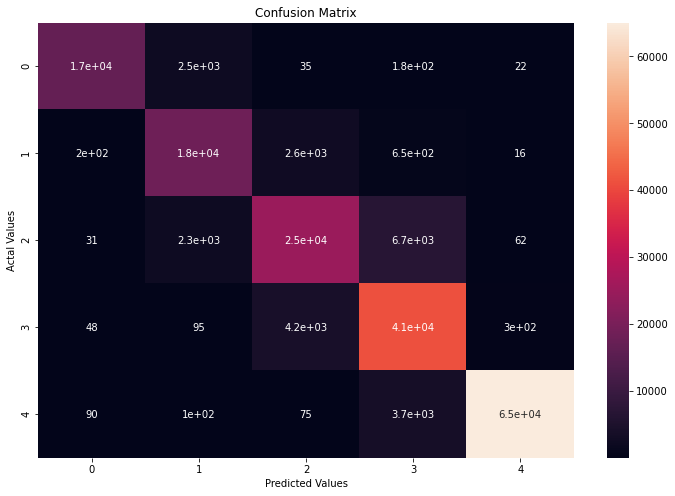

In [13]:
preds_N_cm(model,X_test_transformed,y_train,X_test_transformed,y_test)   

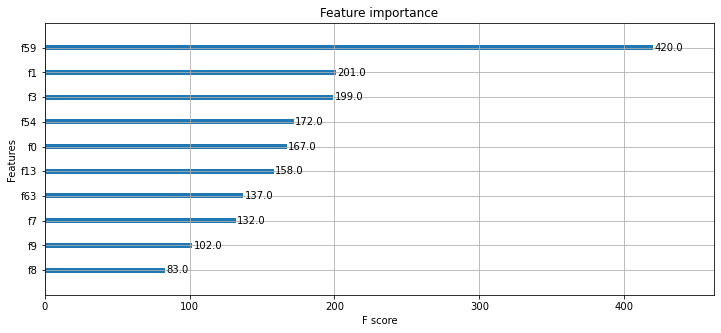

In [14]:
plot_xgb_importance(model,num_features=10)

Accuracy: 88.97%

(micro) precision score:  0.8897164181454597         (macro) precision score:  0.8795245278312706
(micro) f1 score:  0.8897164181454597                (macro) f1 score:  0.8746275120064547

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     19704
           1       0.81      0.85      0.83     21814
           2       0.80      0.76      0.78     34103
           3       0.81      0.91      0.86     45961
           4       1.00      0.95      0.98     68945

    accuracy                           0.89    190527
   macro avg       0.88      0.87      0.87    190527
weighted avg       0.89      0.89      0.89    190527



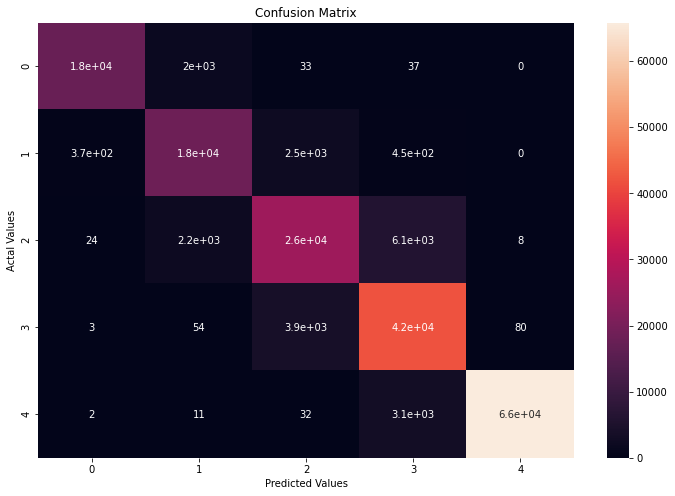

CPU times: user 12.3 s, sys: 390 ms, total: 12.7 s
Wall time: 5.55 s


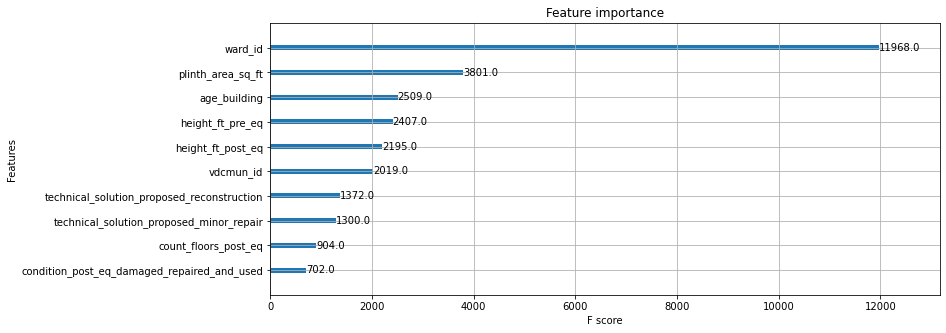

In [16]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=200,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

Accuracy: 89.72%

(micro) precision score:  0.8972114188540207         (macro) precision score:  0.886068812195514
(micro) f1 score:  0.8972114188540207                (macro) f1 score:  0.8825551175936951

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     19704
           1       0.82      0.85      0.84     21814
           2       0.81      0.78      0.79     34103
           3       0.83      0.92      0.87     45961
           4       1.00      0.96      0.98     68945

    accuracy                           0.90    190527
   macro avg       0.89      0.88      0.88    190527
weighted avg       0.90      0.90      0.90    190527



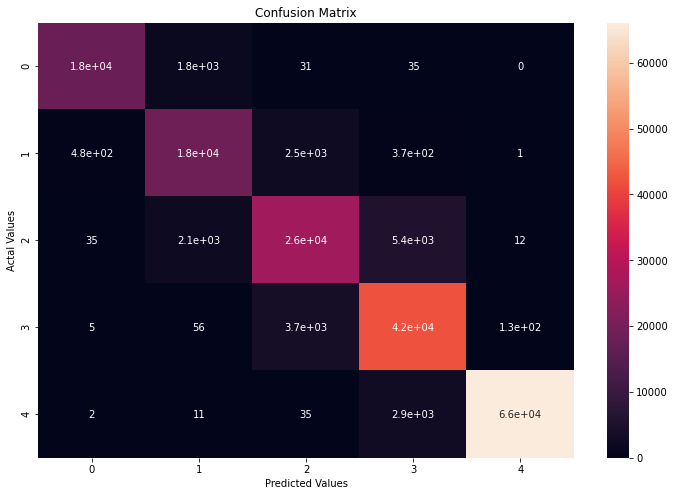

CPU times: user 3h 10min 47s, sys: 2min 33s, total: 3h 13min 20s
Wall time: 1h 20min 12s


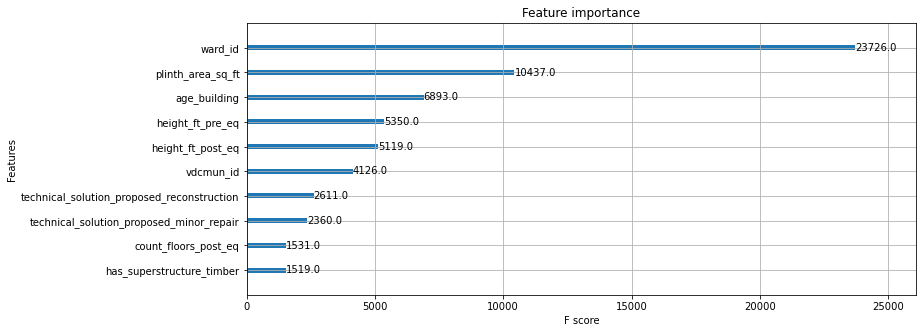

In [18]:
%%time 
# instantiating first model beefing up the number of estimators
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=400,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

Accuracy: 90.31%

(micro) precision score:  0.90306885638256         (macro) precision score:  0.890506267803773
(micro) f1 score:  0.90306885638256                (macro) f1 score:  0.8883679547309351

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.96      0.91      0.94     19704
           1       0.83      0.85      0.84     21814
           2       0.82      0.80      0.81     34103
           3       0.85      0.91      0.88     45961
           4       1.00      0.96      0.98     68945

    accuracy                           0.90    190527
   macro avg       0.89      0.89      0.89    190527
weighted avg       0.91      0.90      0.90    190527



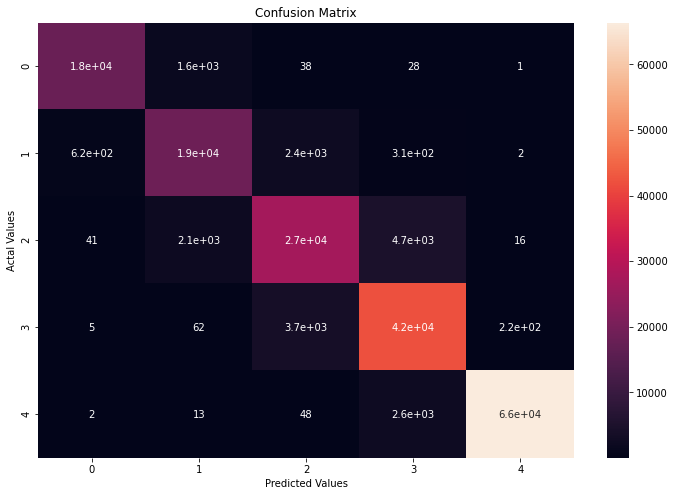

CPU times: user 3h 15min 28s, sys: 1min 47s, total: 3h 17min 15s
Wall time: 1h 3min 56s


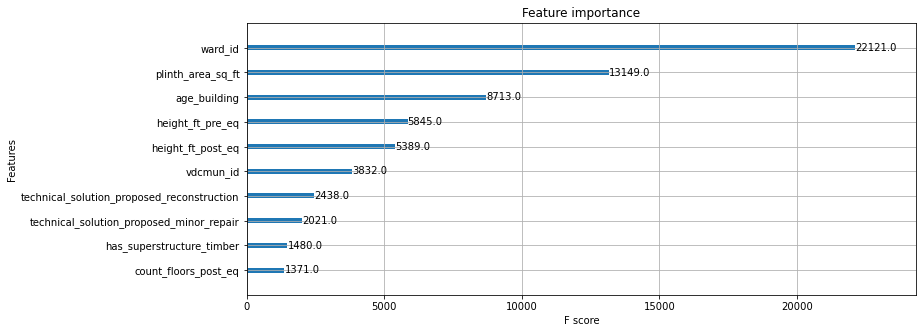

In [19]:
%%time 
# instantiating first model altering the learning rate
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=400,
                      learning_rate=0.2,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

In [21]:
# save in JSON format in folder 
model.save_model("../../Data/model_demo.json")
# save in text format as well
model.save_model("../../Data/model_demo.txt")


# unpickling to ensure it is usable post saving process
model_unpickled = xgb.XGBClassifier()
model_unpickled.load_model("../../Data/model_demo.json")

## A REALIZATION need to drop anything related to the post earthquake information to model future damage

In [5]:
catdf[['condition_post_eq','condition_post_eq','technical_solution_proposed']].head(2)
##### technial_solution_proposed_minor_repair
##### technical_solution_proposed_reconstruction

,condition_post_eq,condition_post_eq,technical_solution_proposed
0,damaged_used_in_risk,damaged_used_in_risk,major_repair
1,damaged_repaired_and_used,damaged_repaired_and_used,reconstruction


In [6]:
pre_eq_cat = catdf.drop(columns=['condition_post_eq','condition_post_eq','technical_solution_proposed'])
pre_eq_cat.head(2)

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
0,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,private
1,flat,other,bamboo_timber_light_roof,mud,not_applicable,not_attached,rectangular,private


In [7]:
dummified_1 = pd.get_dummies(data=pre_eq_cat,drop_first=True) 
dummified_1 = pd.concat([numdf,dummified_1],axis=1)
print(dummified_1.shape)
dummified_1[['count_floors_post_eq' , 'height_ft_post_eq']].head()

(762106, 62)


,count_floors_post_eq,height_ft_post_eq
0,1,9
1,1,9
2,1,9
3,1,9
4,1,9


In [8]:
dummified_1.drop(columns=['count_floors_post_eq' , 'height_ft_post_eq'],inplace=True)
dummified_1.head()

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,plan_configuration_others,plan_configuration_rectangular,plan_configuration_square,plan_configuration_t_shape,plan_configuration_u_shape,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public
0,120101000011,12,1207,120703,1,9,288,9,0,1,0,0,0,0,0,1,0,0,0,3,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
1,120101000021,12,1207,120703,1,15,364,9,0,1,0,0,0,0,0,1,0,0,0,5,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,120101000031,12,1207,120703,1,20,384,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,120101000041,12,1207,120703,1,20,312,9,0,1,0,0,0,0,0,0,0,0,0,2,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
4,120101000051,12,1207,120703,1,30,308,9,0,1,0,0,0,0,0,0,0,0,0,1,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0


In [9]:
# prepping my training and testing batches double checking class balances
X = dummified_1.drop(columns = ['building_id','damage_grade']) 
y = dummified_1['damage_grade']-1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test.unique())
y_test.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

Accuracy: 55.67%

(micro) precision score:  0.5567399896077722         (macro) precision score:  0.5080042588729607
(micro) f1 score:  0.5567399896077722                (macro) f1 score:  0.4963017972392782

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.58      0.74      0.65     19704
           1       0.41      0.21      0.27     21814
           2       0.42      0.33      0.37     34103
           3       0.47      0.46      0.46     45961
           4       0.67      0.79      0.72     68945

    accuracy                           0.56    190527
   macro avg       0.51      0.51      0.50    190527
weighted avg       0.54      0.56      0.54    190527



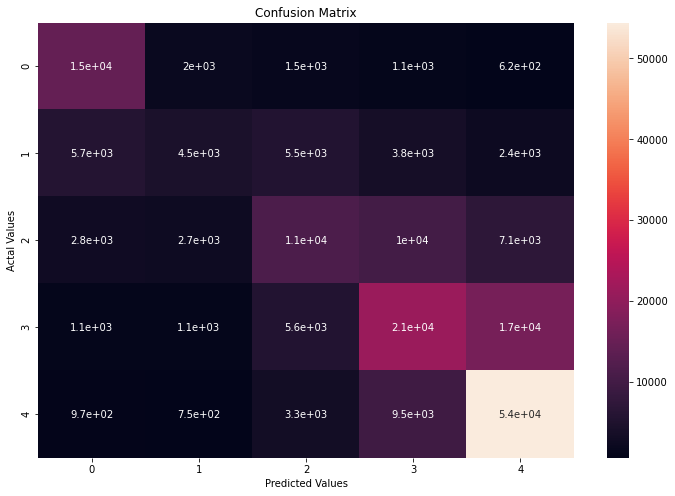

CPU times: user 1h 21min 54s, sys: 1min 13s, total: 1h 23min 8s
Wall time: 42min 4s


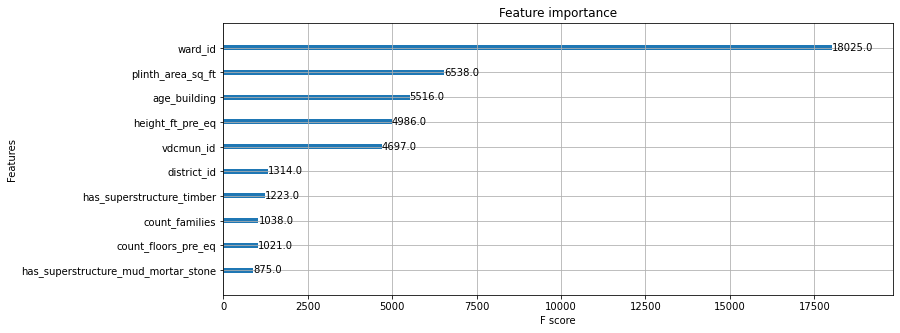

In [86]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=200,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

In [ ]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=250,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

Accuracy: 56.61%

(micro) precision score:  0.5660510058941778         (macro) precision score:  0.5194080940472409
(micro) f1 score:  0.5660510058941778                (macro) f1 score:  0.5099814051077819

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.59      0.74      0.66     19704
           1       0.42      0.23      0.30     21814
           2       0.42      0.35      0.38     34103
           3       0.48      0.48      0.48     45961
           4       0.68      0.79      0.73     68945

    accuracy                           0.57    190527
   macro avg       0.52      0.52      0.51    190527
weighted avg       0.55      0.57      0.55    190527



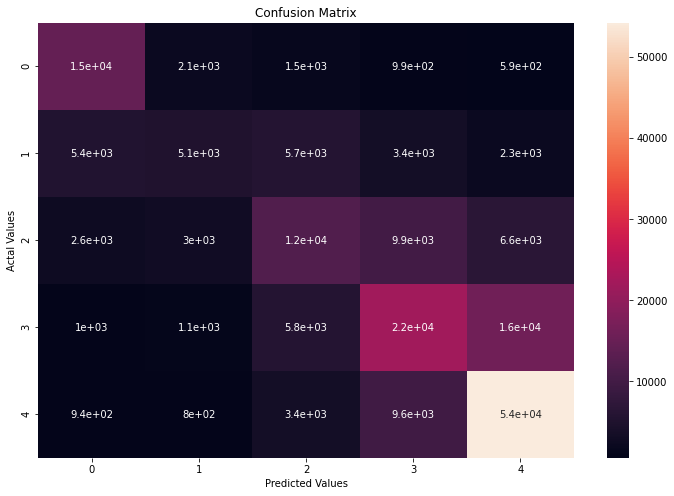

CPU times: user 2h 5min 6s, sys: 52.4 s, total: 2h 5min 58s
Wall time: 52min 26s


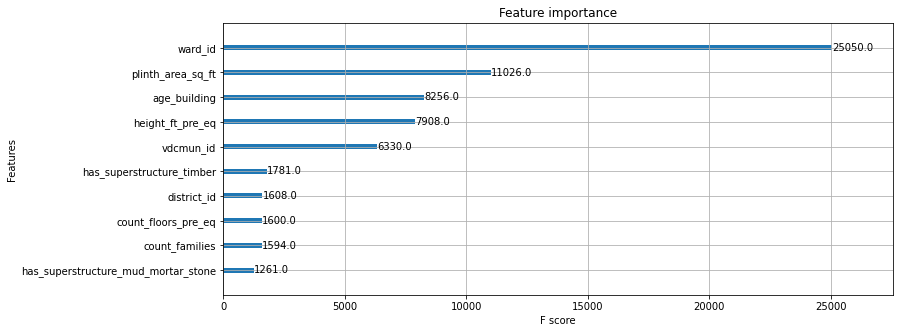

In [14]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=300,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

Accuracy: 57.15%

(micro) precision score:  0.5714780582279677         (macro) precision score:  0.526000506577824
(micro) f1 score:  0.5714780582279677                (macro) f1 score:  0.5182940762006182

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.60      0.74      0.66     19704
           1       0.42      0.25      0.31     21814
           2       0.43      0.36      0.39     34103
           3       0.49      0.49      0.49     45961
           4       0.69      0.78      0.73     68945

    accuracy                           0.57    190527
   macro avg       0.53      0.52      0.52    190527
weighted avg       0.55      0.57      0.56    190527



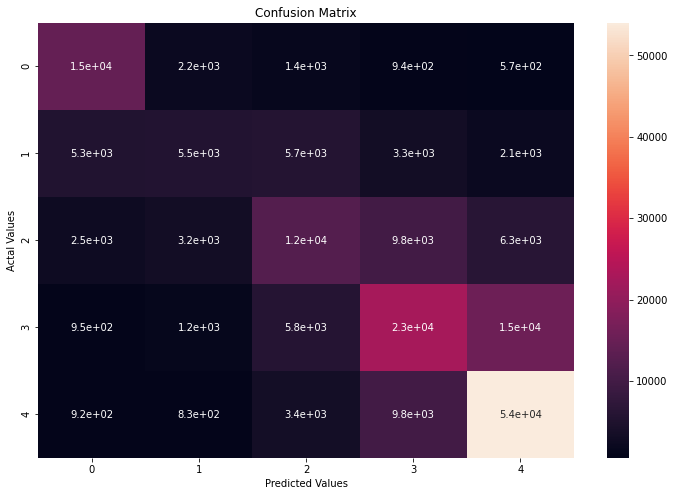

CPU times: user 2h 47min, sys: 1min 49s, total: 2h 48min 49s
Wall time: 58min 26s


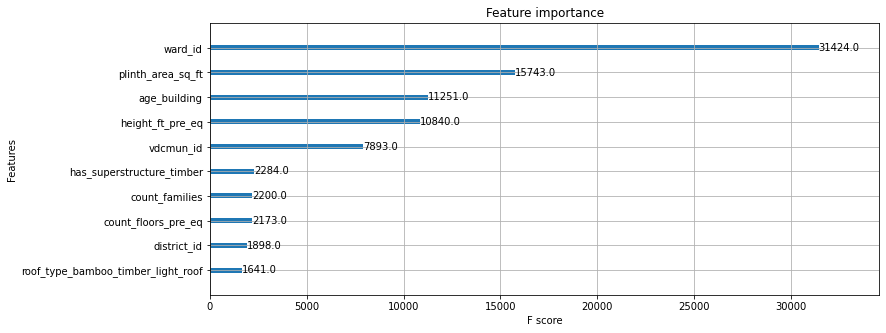

In [9]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=400,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

In [63]:
#.  
X.to_pickle('../../Data/model_df.pickle')


In [59]:
with open('../../Data/columns_list.pkl', 'wb') as pickle_out:
    columns = pickle.dump(X.columns.tolist(),pickle_out)

Accuracy: 51.34%

(micro) precision score:  0.513386554136684         (macro) precision score:  0.45466167541838975
(micro) f1 score:  0.513386554136684                (macro) f1 score:  0.42444577579619286

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.52      0.75      0.62     19704
           1       0.38      0.10      0.16     21814
           2       0.38      0.20      0.26     34103
           3       0.39      0.39      0.39     45961
           4       0.60      0.82      0.69     68945

    accuracy                           0.51    190527
   macro avg       0.45      0.45      0.42    190527
weighted avg       0.48      0.51      0.47    190527



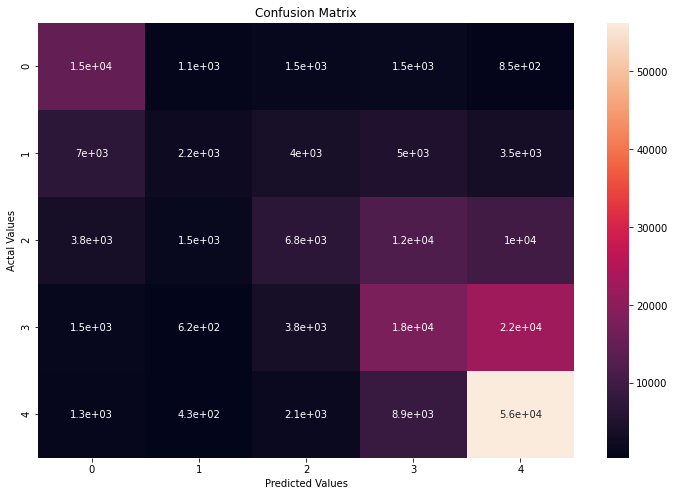

CPU times: user 2h 47min 40s, sys: 3min, total: 2h 50min 40s
Wall time: 1h 7min 7s


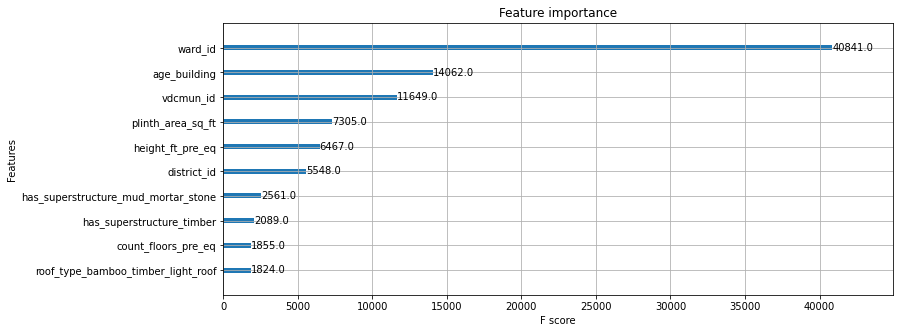

In [10]:
%%time 
# instantiating first model (most of these are defaults)
model = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=400,
                      learning_rate=0.01,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model.fit(X_train,y_train)
preds_N_cm(model,X_train,y_train,X_test,y_test)   
plot_xgb_importance(model,num_features=10)

### Checking Polynomial Features and performance

In [11]:
features=X.columns[3:] # dont need to the IDs included in the feature expansion

In [14]:
poly = PolynomialFeatures(include_bias = False)
# Create X_poly
X_poly = poly.fit_transform(X[features])


In [15]:
# View X_poly in a DataFrame
X_poly_df =pd.DataFrame(X_poly, columns = poly.get_feature_names(features))
X_poly_df.head(2)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,plan_configuration_others,plan_configuration_rectangular,plan_configuration_square,...,plan_configuration_l_shape plan_configuration_t_shape,plan_configuration_l_shape plan_configuration_u_shape,plan_configuration_l_shape legal_ownership_status_other,plan_configuration_l_shape legal_ownership_status_private,plan_configuration_l_shape legal_ownership_status_public,plan_configuration_multi_projected^2,plan_configuration_multi_projected plan_configuration_others,plan_configuration_multi_projected plan_configuration_rectangular,plan_configuration_multi_projected plan_configuration_square,plan_configuration_multi_projected plan_configuration_t_shape,plan_configuration_multi_projected plan_configuration_u_shape,plan_configuration_multi_projected legal_ownership_status_other,plan_configuration_multi_projected legal_ownership_status_private,plan_configuration_multi_projected legal_ownership_status_public,plan_configuration_others^2,plan_configuration_others plan_configuration_rectangular,plan_configuration_others plan_configuration_square,plan_configuration_others plan_configuration_t_shape,plan_configuration_others plan_configuration_u_shape,plan_configuration_others legal_ownership_status_other,plan_configuration_others legal_ownership_status_private,plan_configuration_others legal_ownership_status_public,plan_configuration_rectangular^2,plan_configuration_rectangular plan_configuration_square,plan_configuration_rectangular plan_configuration_t_shape,plan_configuration_rectangular plan_configuration_u_shape,plan_configuration_rectangular legal_ownership_status_other,plan_configuration_rectangular legal_ownership_status_private,plan_configuration_rectangular legal_ownership_status_public,plan_configuration_square^2,plan_configuration_square plan_configuration_t_shape,plan_configuration_square plan_configuration_u_shape,plan_configuration_square legal_ownership_status_other,plan_configuration_square legal_ownership_status_private,plan_configuration_square legal_ownership_status_public,plan_configuration_t_shape^2,plan_configuration_t_shape plan_configuration_u_shape,plan_configuration_t_shape legal_ownership_status_other,plan_configuration_t_shape legal_ownership_status_private,plan_configuration_t_shape legal_ownership_status_public,plan_configuration_u_shape^2,plan_configuration_u_shape legal_ownership_status_other,plan_configuration_u_shape legal_ownership_status_private,plan_configuration_u_shape legal_ownership_status_public,legal_ownership_status_other^2,legal_ownership_status_other legal_ownership_status_private,legal_ownership_status_other legal_ownership_status_public,legal_ownership_status_private^2,legal_ownership_status_private legal_ownership_statu

In [16]:
X_poly_df = pd.concat([X[['district_id', 'vdcmun_id', 'ward_id']],X_poly_df],axis=1)
X_poly_df.head(2)

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,...,plan_configuration_l_shape plan_configuration_t_shape,plan_configuration_l_shape plan_configuration_u_shape,plan_configuration_l_shape legal_ownership_status_other,plan_configuration_l_shape legal_ownership_status_private,plan_configuration_l_shape legal_ownership_status_public,plan_configuration_multi_projected^2,plan_configuration_multi_projected plan_configuration_others,plan_configuration_multi_projected plan_configuration_rectangular,plan_configuration_multi_projected plan_configuration_square,plan_configuration_multi_projected plan_configuration_t_shape,plan_configuration_multi_projected plan_configuration_u_shape,plan_configuration_multi_projected legal_ownership_status_other,plan_configuration_multi_projected legal_ownership_status_private,plan_configuration_multi_projected legal_ownership_status_public,plan_configuration_others^2,plan_configuration_others plan_configuration_rectangular,plan_configuration_others plan_configuration_square,plan_configuration_others plan_configuration_t_shape,plan_configuration_others plan_configuration_u_shape,plan_configuration_others legal_ownership_status_other,plan_configuration_others legal_ownership_status_private,plan_configuration_others legal_ownership_status_public,plan_configuration_rectangular^2,plan_configuration_rectangular plan_configuration_square,plan_configuration_rectangular plan_configuration_t_shape,plan_configuration_rectangular plan_configuration_u_shape,plan_configuration_rectangular legal_ownership_status_other,plan_configuration_rectangular legal_ownership_status_private,plan_configuration_rectangular legal_ownership_status_public,plan_configuration_square^2,plan_configuration_square plan_configuration_t_shape,plan_configuration_square plan_configuration_u_shape,plan_configuration_square legal_ownership_status_other,plan_configuration_square legal_ownership_status_private,plan_configuration_square legal_ownership_status_public,plan_configuration_t_shape^2,plan_configuration_t_shape plan_configuration_u_shape,plan_configuration_t_shape legal_ownership_status_other,plan_configuration_t_shape legal_ownership_status_private,plan_configuration_t_shape legal_ownership_status_public,plan_configuration_u_shape^2,plan_configuration_u_shape legal_ownership_status_other,plan_configuration_u_shape legal_ownership_status_private,plan_configuration_u_shape legal_ownership_status_public,legal_ownership_status_other^2,legal_ownership_status_other legal_ownership_status_private,legal_ownership_status_other legal_ownership_status_public,legal_ownership_status_private^2,legal_ownership_status_private legal_ownership_status_public,legal_ownership_status_public^2
0,12,1207,12

In [17]:
len([column for column in X_poly_df.columns.tolist() if '^2' not in column]) # only getting the non squared values

1543

In [18]:
X_poly_sq=[column for column in X_poly_df.columns.tolist() if '^2' in column]


In [19]:
X_poly_non_sq=[column for column in X_poly_df.columns.tolist() if '^2' not in column]

In [20]:
print(X_poly_df.shape)
print(X_poly_df[X_poly_non_sq[:100]].shape)

(762106, 1598)
(762106, 100)


In [21]:
X_poly_df[X_poly_non_sq[:100]].head()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_moderate_slope,land_surface_condition_steep_slope,foundation_type_cement_stone_brick,foundation_type_mud_mortar_stone_brick,foundation_type_other,foundation_type_rc,roof_type_bamboo_timber_light_roof,roof_type_rcc_rb_rbc,ground_floor_type_mud,ground_floor_type_other,ground_floor_type_rc,ground_floor_type_timber,other_floor_type_rcc_rb_rbc,other_floor_type_timber_bamboo_mud,other_floor_type_timber_planck,position_not_attached,plan_configuration_e_shape,plan_configuration_h_shape,plan_configuration_l_shape,plan_configuration_multi_projected,plan_configuration_others,plan_configuration_rectangular,plan_configuration_square,plan_configuration_t_shape,plan_configuration_u_shape,legal_ownership_status_other,legal_ownership_status_private,legal_ownership_status_public,count_floors_pre_eq age_building,count_floors_pre_eq plinth_area_sq_ft,count_floors_pre_eq height_ft_pre_eq,count_floors_pre_eq has_superstructure_adobe_mud,count_floors_pre_eq has_superstructure_mud_mortar_stone,count_floors_pre_eq has_superstructure_stone_flag,count_floors_pre_eq has_superstructure_cement_mortar_stone,count_floors_pre_eq has_superstructure_mud_mortar_brick,count_floors_pre_eq has_superstructure_cement_mortar_brick,count_floors_pre_eq has_superstructure_timber,count_floors_pre_eq has_superstructure_bamboo,count_floors_pre_eq has_superstructure_rc_non_engineered,count_floors_pre_eq has_superstructure_rc_engineered,count_floors_pre_eq has_superstructure_other,count_floors_pre_eq count_families,count_floors_pre_eq has_secondary_use,count_floors_pre_eq has_secondary_use_agriculture,count_floors_pre_eq has_secondary_use_hotel,count_floors_pre_eq has_secondary_use_rental,count_floors_pre_eq has_secondary_use_institution,count_floors_pre_eq has_secondary_use_school,count_floors_pre_eq has_secondary_use_industry,count_floors_pre_eq has_secondary_use_health_post,count_floors_pre_eq has_secondary_use_gov_office,count_floors_pre_eq has_secondary_use_use_police,count_floors_pre_eq has_secondary_use_other,count_floors_pre_eq land_surface_condition_moderate_slope,count_floors_pre_eq land_surface_condition_steep_slope,count_floors_pre_eq foundation_type_cement_stone_brick,count_floors_pre_eq foundation_type_mud_mortar_stone_brick,count_floors_pre_eq foundation_type_other,count_floors_pre_eq foundation_type_rc,count_floors_pre_eq roof_type_bamboo_timber_light_roof,count_floors_pre_eq roof_type_rcc_rb_rbc,count_floors_pre_eq ground_floor_type_mud,count_floors_pre_eq ground_floor_type_other,count_floors_pre_eq ground_floor_type_rc,count_floors_pre_eq ground_floor_type_timber,count_floors_pre_eq other_floor_type_rcc_rb_rbc,count_floors_pre_eq other_floor_type_timber_bamboo_mud,count_floors_pre_eq other_floor_type_timber_planck,count_floors_pre_eq position_not_attached
0,12,1207,120703,1.0,9.0,288.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,288.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,12,1207,120703,1.0,15.0,364.0,9

In [24]:
# first hundred
first_hund = X_poly_df[X_poly_non_sq[:100]]

In [23]:
# cutting 
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(first_hund, 
                                                    y, #test_size=.4,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)
print(y_test_poly.unique())
y_test_poly.value_counts(normalize=True) # double checking that it was stratified 

[3 0 4 1 2]


4    0.361865
3    0.241231
2    0.178993
1    0.114493
0    0.103418
Name: damage_grade, dtype: float64

Accuracy: 51.85%

(micro) precision score:  0.5185196848740599         (macro) precision score:  0.46126565513153894
(micro) f1 score:  0.5185196848740599                (macro) f1 score:  0.4351316109219769

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.53      0.74      0.62     19704
           1       0.38      0.12      0.18     21814
           2       0.38      0.22      0.28     34103
           3       0.40      0.39      0.40     45961
           4       0.61      0.81      0.70     68945

    accuracy                           0.52    190527
   macro avg       0.46      0.46      0.44    190527
weighted avg       0.48      0.52      0.48    190527



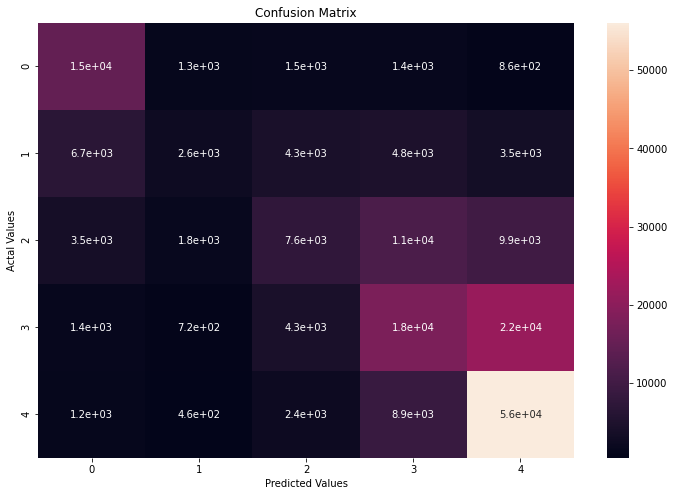

CPU times: user 34min 48s, sys: 13.6 s, total: 35min 1s
Wall time: 9min 39s


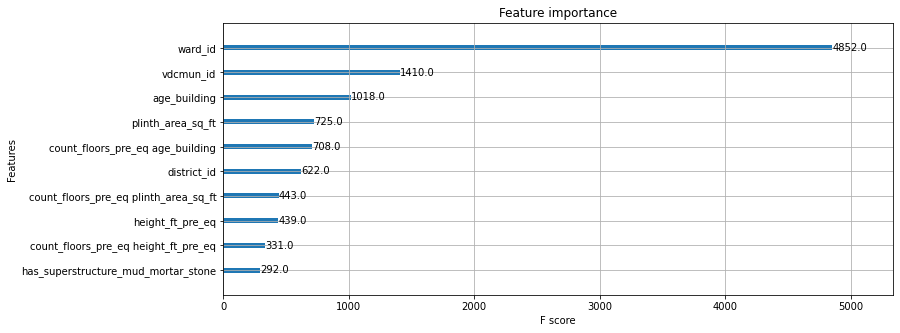

In [25]:
%%time 
# instantiating first model (most of these are defaults)
model_poly = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=50,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model_poly.fit(X_train_poly,y_train_poly)

preds_N_cm(model_poly,X_train_poly,y_train_poly,X_test_poly,y_test_poly)   
plot_xgb_importance(model_poly,num_features=10)

Accuracy: 51.96%

(micro) precision score:  0.519606145060805         (macro) precision score:  0.46217136726962915
(micro) f1 score:  0.519606145060805                (macro) f1 score:  0.43463878755152513

XGBoost Classificaition Report
              precision    recall  f1-score   support

           0       0.53      0.76      0.62     19704
           1       0.38      0.11      0.17     21814
           2       0.39      0.23      0.29     34103
           3       0.41      0.39      0.40     45961
           4       0.61      0.81      0.70     68945

    accuracy                           0.52    190527
   macro avg       0.46      0.46      0.43    190527
weighted avg       0.49      0.52      0.48    190527



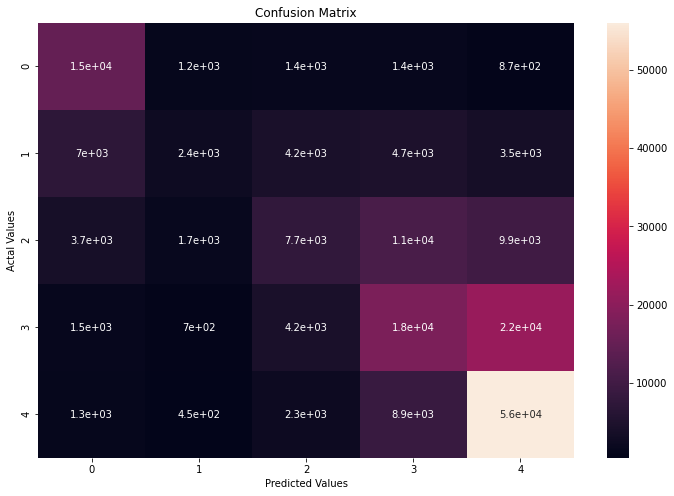

CPU times: user 1h 9min 35s, sys: 52.2 s, total: 1h 10min 27s
Wall time: 24min 18s


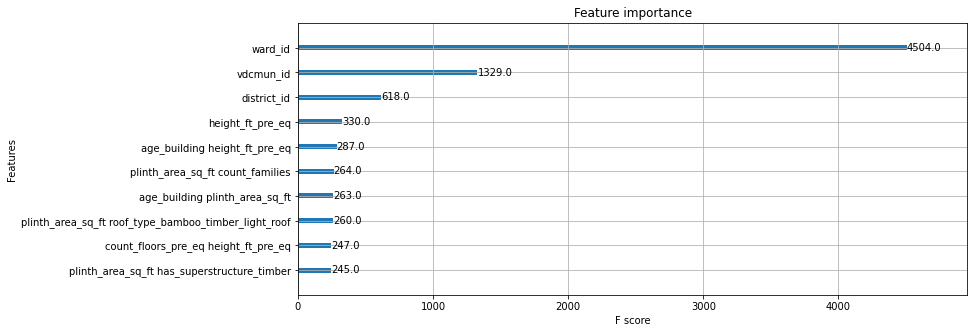

In [27]:
first_2hund = X_poly_df[X_poly_non_sq[:200]]
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(first_2hund, 
                                                    y, #test_size=.4,
                                                    stratify=y,
                                                    shuffle=True,
                                                    random_state=42)

%%time 
# instantiating first model (most of these are defaults)
model_poly = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=50,
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)
model_poly.fit(X_train_poly,y_train_poly)

preds_N_cm(model_poly,X_train_poly,y_train_poly,X_test_poly,y_test_poly)   
plot_xgb_importance(model_poly,num_features=10)

In [32]:
# trying random parameters 
model_poly = XGBClassifier(objective='multi:softmax',
                      seed=42,
                      n_estimators=150,max_depth=10,eval_metric='merror',
                      learning_rate=0.1,
                      booster='gbtree',
                      reg_alpha=0,
                      max_delta_step=0)


CPU times: user 37 µs, sys: 1e+03 ns, total: 38 µs
Wall time: 42 µs


In [ ]:
%%time 
model_poly.fit(X_train_poly,y_train_poly)

preds_N_cm(model_poly,X_train_poly,y_train_poly,X_test_poly,y_test_poly)   
plot_xgb_importance(model_poly,num_features=10)